In [3]:
import os
import torch
import numpy as np
from PIL import Image
from transformers import AutoModel
from transformers import AutoVideoProcessor
import sklearn as sk
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/Users/shamik/Library/Mobile Documents/com~apple~CloudDocs/Documents/shampro-cloud/rpi/urp/AV-SSL-Optimization-JEPA/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
hf_model_name = (
    "facebook/vjepa2-vitl-fpc64-256"  # Replace with your favored model, e.g. facebook/vjepa2-vitg-fpc64-384
)

# initialize model weights from huggingface
model_hf = AutoModel.from_pretrained(hf_model_name)
model_hf.to("mps", dtype = torch.float32).eval() 

# load model weights
hf_transform = AutoVideoProcessor.from_pretrained(hf_model_name)

In [5]:
# creating scenes for testing encoder

tubelet_size = 2 # size of temporal data
data_dir = 'data'
tubelet_videos = [] # elements of (tubelet_size, H, W, 3)
tubelet_meta = [] # list of (scene_name, tubelet index within scene)

# ensure deterministic scene order
scene_names = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])

for scene in scene_names:
    folder_path = os.path.join(data_dir, scene)
    frame_files = sorted(
        f for f in os.listdir(folder_path)
        if os.path.isfile(os.path.join(folder_path, f))
    )

    frames = [] 

    # ensure deterministic frame order within each scene
    for file in sorted(os.listdir(folder_path)):
        img_path = os.path.join(folder_path, file)
        img = Image.open(img_path).convert("RGB")
        frames.append(np.array(img))

    # make non-overlapping tubeletes
    num_tubelets = len(frames) // tubelet_size
    for t_idx in range(num_tubelets):
        start = t_idx * tubelet_size
        tube = np.stack(frames[start:start + tubelet_size], axis = 0)
        tubelet_videos.append(tube)
        tubelet_meta.append((scene,  t_idx))

    
    print(f"{scene}: {len(frames)} frames -> {num_tubelets} tubelets")

scene1: 16 frames -> 8 tubelets
scene2: 16 frames -> 8 tubelets
scene3: 16 frames -> 8 tubelets
scene4: 16 frames -> 8 tubelets
scene5: 16 frames -> 8 tubelets
scene6: 16 frames -> 8 tubelets


In [6]:
for pairs in tubelet_videos:
    print(pairs.shape)

(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)
(2, 900, 1600, 3)


In [7]:
# check model encoder

embeddings = [] # elements of (W, ) embedding vectors

for video in tubelet_videos:
    inputs = hf_transform(video, return_tensors = 'pt')
    inputs = {k: v.to(model_hf.device) for k, v, in inputs.items()}

    with torch.no_grad():
        feats = model_hf.get_vision_features(**inputs) # (1, H, W)
        print("feats shape ", feats.shape)
        clip_emb = feats.mean(dim=1).squeeze(0).cpu().numpy() # global average pooling for downstream
        print("clim emb shape ", clip_emb.shape)
        embeddings.append(clip_emb)  


tubelet_embds = np.stack(embeddings, axis = 0) # tensor of all our embeddings

feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])
clim emb shape  (1024,)
feats shape  torch.Size([1, 256, 1024])


In [8]:
# normalize
tubelet_embds_norm = tubelet_embds / np.linalg.norm(tubelet_embds)

In [12]:
# computing PCA 

# Select features X: prefer tubelet embeddings if present
if 'tubelet_embds_norm' in globals():
    X = tubelet_embds_norm  # (N_tubelets, D)
    meta = tubelet_meta
    use_tubelets = True
else:
    # fallback to scene-level
    X = clip_embds / np.maximum(np.linalg.norm(clip_embds, axis=1, keepdims=True), 1e-12)
    meta = [(scene_names[i] if 'scene_names' in globals() else f'scene_{i+1}', 0) for i in range(len(X))]
    use_tubelets = False

pca3 = sk.decomposition.PCA(n_components=3)
emb_3d = pca3.fit_transform(X)
pca2 = sk.decomposition.PCA(n_components = 2)
emb_2d = pca2.fit_transform(X)


/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_83353/881754908.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab10').colors


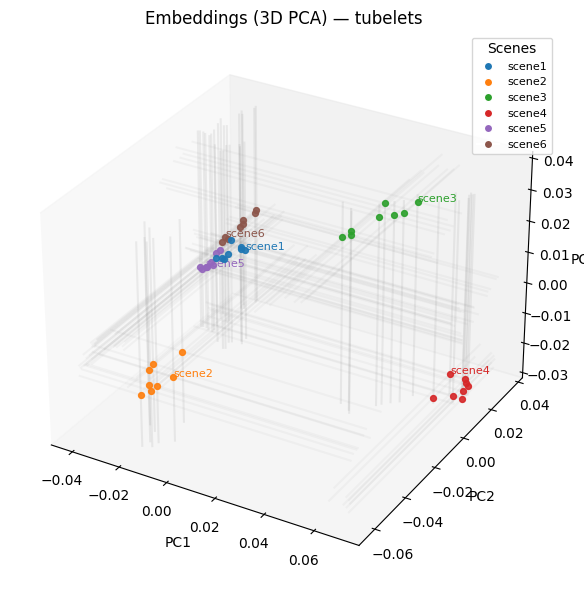

In [14]:
# 3d plotting

# Colors by scene
scenes_unique = sorted({m[0] for m in meta})
palette = plt.cm.get_cmap('tab10').colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

fig = plt.figure(figsize=(7, 6))
ax = fig.add_subplot(111, projection='3d')

for (x, y, z), (scene, t_idx) in zip(emb_3d, meta):
    ax.scatter(x, y, z, color=color_map[scene], s=18, alpha=0.9)

# annotate one representative point per scene to avoid clutter
for scene in scenes_unique:
    k = next((i for i, m in enumerate(meta) if m[0] == scene), None)
    if k is not None:
        xi, yi, zi = emb_3d[k]
        ax.text(xi, yi, zi, scene, fontsize=8, color=color_map[scene])

ax.grid(True)
for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
    try:
        axis._axinfo["grid"]["linewidth"] = 0.0
    except Exception:
        pass

# faint guides
mins, maxs = emb_3d.min(axis=0), emb_3d.max(axis=0)
for x, y, z in emb_3d:
    ax.plot([x, x], [y, y], [mins[2], maxs[2]], color='gray', alpha=0.12)
    ax.plot([x, x], [mins[1], maxs[1]], [z, z], color='gray', alpha=0.06)
    ax.plot([mins[0], maxs[0]], [y, y], [z, z], color='gray', alpha=0.06)

handles = [plt.Line2D([0],[0], marker='o', color='w', label=s,
                      markerfacecolor=color_map[s], markersize=6)
           for s in scenes_unique]
ax.legend(handles=handles, title='Scenes', loc='best', fontsize=8)

ax.set_title('Embeddings (3D PCA)' + (' — tubelets' if use_tubelets else ' — scenes'))
ax.set_xlabel('PC1'); ax.set_ylabel('PC2'); ax.set_zlabel('PC3')
plt.tight_layout()
plt.show()


/var/folders/61/qgw87yz91l7fqxmfslbk4wd40000gn/T/ipykernel_83353/2529983703.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  palette = plt.cm.get_cmap('tab20').colors  # list of 10 RGBA colors


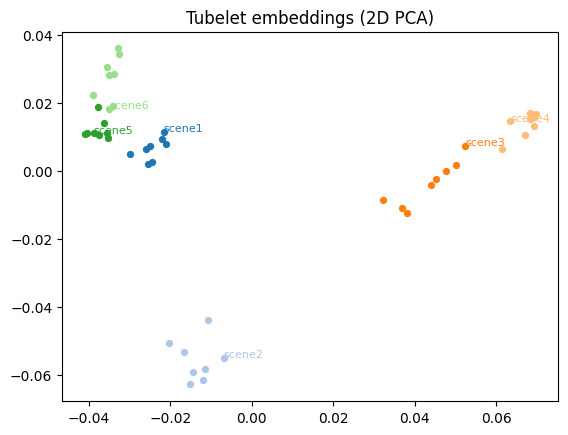

In [15]:
scenes_unique = sorted({m[0] for m in tubelet_meta})
palette = plt.cm.get_cmap('tab20').colors  # list of 10 RGBA colors
color_map = {s: palette[i % len(palette)] for i, s in enumerate(scenes_unique)}

plt.figure()
for (x, y), (scene, t_idx) in zip(emb_2d, tubelet_meta):
    plt.scatter(x, y, color=color_map[scene], s=18)
plt.title("Tubelet embeddings (2D PCA)")


for scene in scenes_unique:
    k = next(i for i, m in enumerate(tubelet_meta) if m[0] == scene)
    x, y = emb_2d[k]
    plt.text(x, y, scene, fontsize=8, color=color_map[scene])

plt.show()


In [16]:
# compute similarities

sims = sk.metrics.pairwise.cosine_similarity(tubelet_embds_norm)
with np.printoptions(threshold=np.inf, linewidth=np.inf):
    print(np.round(sims, 3))

[[1.    0.984 0.98  0.981 0.99  0.982 0.976 0.962 0.851 0.83  0.838 0.844 0.818 0.89  0.866 0.853 0.803 0.812 0.822 0.83  0.839 0.817 0.825 0.859 0.781 0.766 0.757 0.763 0.763 0.772 0.763 0.765 0.92  0.935 0.931 0.926 0.912 0.926 0.932 0.933 0.95  0.949 0.958 0.951 0.945 0.953 0.953 0.955]
 [0.984 1.    0.992 0.988 0.99  0.981 0.986 0.982 0.852 0.844 0.854 0.854 0.837 0.891 0.88  0.869 0.8   0.812 0.824 0.835 0.852 0.82  0.834 0.866 0.767 0.755 0.743 0.743 0.742 0.753 0.746 0.75  0.934 0.946 0.936 0.942 0.938 0.943 0.937 0.946 0.955 0.956 0.953 0.94  0.933 0.949 0.944 0.949]
 [0.98  0.992 1.    0.994 0.99  0.978 0.989 0.989 0.867 0.866 0.875 0.876 0.86  0.898 0.895 0.881 0.793 0.807 0.82  0.831 0.851 0.812 0.83  0.865 0.771 0.761 0.745 0.745 0.739 0.751 0.745 0.75  0.937 0.942 0.934 0.947 0.943 0.947 0.939 0.945 0.954 0.958 0.951 0.933 0.924 0.944 0.941 0.947]
 [0.981 0.988 0.994 1.    0.993 0.987 0.993 0.987 0.874 0.871 0.88  0.882 0.863 0.906 0.901 0.885 0.801 0.814 0.828 0.838 0.856

In [18]:
from collections import defaultdict 
scene_to_indices = defaultdict(list)
for idx, (scene, _) in enumerate(tubelet_meta):
    scene_to_indices[scene].append(idx)

scene_names_unique = sorted(scene_to_indices.keys())

# Build per-scene embeddings
scene_embeds = []
for s in scene_names_unique:
    idxs = scene_to_indices[s]
    if 'tubelet_embds' in globals() and tubelet_embds is not None:
        agg = np.mean(tubelet_embds[idxs], axis=0)  # average raw tubelet embeddings
    else:
        agg = np.mean(tubelet_embds_norm[idxs], axis=0)  # fallback: average normalized
    scene_embeds.append(agg)

scene_embeds = np.stack(scene_embeds, axis=0)  # (S, D)

# L2-normalize scene embeddings
scene_norm = scene_embeds / np.maximum(np.linalg.norm(scene_embeds, axis=1, keepdims=True), 1e-12)

# Cosine similarity per scene
sims_scene = sk.metrics.pairwise.cosine_similarity(scene_norm)

# Pretty print with labels (no truncation)
labels = scene_names_unique
with np.printoptions(precision=3, suppress=True, threshold=np.inf, linewidth=200):
    print("Scenes:", labels)
    print(np.round(sims_scene, 3))

Scenes: ['scene1', 'scene2', 'scene3', 'scene4', 'scene5', 'scene6']
[[1.    0.881 0.842 0.77  0.948 0.964]
 [0.881 1.    0.805 0.72  0.849 0.816]
 [0.842 0.805 1.    0.901 0.784 0.794]
 [0.77  0.72  0.901 1.    0.715 0.733]
 [0.948 0.849 0.784 0.715 1.    0.954]
 [0.964 0.816 0.794 0.733 0.954 1.   ]]
